In [1]:
# import packages
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from scipy.stats import ttest_ind
import statsmodels.stats.multitest as smm
from adjustText import adjust_text
import os

from statannotations.Annotator import Annotator

In [2]:
# Load data 
output_dir = '../../LCMS/'

# Load the Excel file
excel_file = os.path.join(output_dir, '9705.SUB14547_MetabolomicsData.xlsx')

# Load the sheet into a DataFrame
sheet_name = 'Untargeted'  # Replace with the actual sheet name if different
data = pd.read_excel(excel_file, sheet_name=sheet_name)
metadata = pd.read_excel(excel_file, sheet_name='SamplesNames')

/Users/djuna/Library/Python/3.9/lib/python/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


In [67]:
meta = metadata.iloc[3:22]
meta['grp'] = [x.split('_')[-1] for x in meta['Unnamed: 1']]

/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_71290/3882753133.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['grp'] = [x.split('_')[-1] for x in meta['Unnamed: 1']]


In [68]:
dictionary_grp = dict(zip(meta['grp'], meta['Unnamed: 3']))
dictionary_date = dict(zip(meta['grp'], meta['Unnamed: 4']))

In [69]:
dictionary_grp

{'SPL01': 'Y622_H2O',
 'SPL02': 'Y622_CDPCholine',
 'SPL03': 'Y622_CDPCholine',
 'SPL04': 'Y622_H2O',
 'SPL05': 'Y622_CDPCholine',
 'SPL06': 'Y622_CDPCholine',
 'SPL07': 'E3_H2O',
 'SPL08': 'E3_H2O',
 'SPL09': 'E3_H2O',
 'SPL10': 'E3_H2O',
 'SPL11': 'Y622_H2O',
 'SPL12': 'Y622_H2O',
 'SPL13': 'Y622_CDPCholine',
 'SPL14': 'Y622_CDPCholine',
 'SPL15': 'Y622_CDPCholine',
 'SPL16': 'Y622_CDPCholine',
 'SPL17': 'G2_H2O',
 'SPL18': 'G2_H2O',
 'SPL19': 'G2_H2O'}

In [73]:
areas = data.iloc[7:,49:68]
areas.columns = data.iloc[4,49:68]

In [74]:
dates = areas.columns.map(dictionary_date)
names = areas.columns.map(dictionary_grp)

In [75]:
areas.shape

(1240, 19)

In [76]:

areas_selected = areas.loc[:,dates == '4_24']
names_selected = names[dates == '4_24']

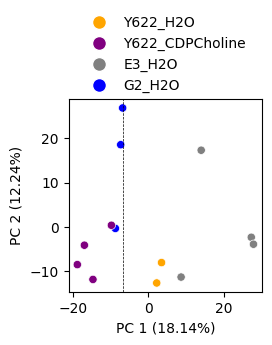

In [77]:
# only look at E3 vs G2


# perform PCA
scaler = StandardScaler()
norm_areas_subset_no_background_scaled = scaler.fit_transform(areas_selected.T)

pca = PCA(n_components=4)
principal_components = pca.fit_transform(norm_areas_subset_no_background_scaled)
principal_components = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])
principal_components['condition'] = names_selected

# plot PCA
plt.figure(figsize=(2.5, 2.5))
palette = {'E3_H2O': 'grey', 'Y622_H2O' : 'orange', 'G2_H2O': 'blue', 'Y622_CDPCholine' : 'purple'}
sns.scatterplot(x='PC1', y='PC2', hue='condition', data=principal_components, palette=palette, edgecolor='w')
explained_variance = pca.explained_variance_ratio_
plt.xlabel(f'PC 1 ({explained_variance[0]*100:.2f}%)')
plt.ylabel(f'PC 2 ({explained_variance[1]*100:.2f}%)')
plt.legend(title='Line', bbox_to_anchor=(1.05, 1), loc='upper left')
# Remove the existing legend
plt.legend([],[], frameon=False)

# Add a custom legend based on marker type
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor='orange', markersize=10,linestyle='None', label='Y622_H2O'),
    Line2D([0], [0], marker='o', markerfacecolor='purple',color='w',
           markersize=10, linestyle='None', label='Y622_CDPCholine'),
               Line2D([0], [0], marker='o', markerfacecolor='grey',color='w',
           markersize=10, linestyle='None', label='E3_H2O'),
               Line2D([0], [0], marker='o', markerfacecolor='blue',color='w',
           markersize=10, linestyle='None', label='G2_H2O')
]
plt.legend(handles=legend_elements, title='', bbox_to_anchor=(.5, 1.5), loc='upper center', frameon=False)
# Add vertical line along the mean of PC1
mean_pc1 = principal_components['PC1'].median()
plt.axvline(x=mean_pc1, color='black', linestyle='--',  linewidth=0.5)



In [78]:
# Are there any annotations based on the blank used for background subtraction?

# I don't see any extraction blank columns so we don't have to check for higher signal in the non-blanks vs the blanks
'Background' in set(data.iloc[:,2].unique())


False

In [79]:
set(data.iloc[:,2].unique())

{'Bad integration;FISHhit',
 'FISHhit',
 'Level 1 ID',
 'Level 2 ID',
 'MasslistRT ID',
 'Other ID',
 'Tags',
 'Tags\nImportant, please read report',
 'Weak/poor match',
 nan}

In [80]:
# get stats data
compoundnames = np.array(data.iloc[7:,1])
tags = np.array(data.iloc[7:,2])

In [81]:
names_selected

Index(['E3_H2O', 'E3_H2O', 'E3_H2O', 'E3_H2O', 'G2_H2O', 'G2_H2O', 'G2_H2O',
       'Y622_CDPCholine', 'Y622_CDPCholine', 'Y622_CDPCholine',
       'Y622_CDPCholine', 'Y622_H2O', 'Y622_H2O'],
      dtype='object', name=4)

In [85]:
from scipy.stats import ttest_ind

# Assuming 'data' is a DataFrame with the relevant data
# and 'names_no_blank' is a list or array of group labels corresponding to the rows in 'data'

# Create a dictionary to store t-test results for each row
t_test_results = {}

# Iterate over each row in the data
for index, row in areas_selected.iterrows():
    # Get the values for the current row
    values = row.values.astype(float)
    # Separate the values into two groups based on 'names_no_blank'
    group1 = values[names_selected == 'E3_H2O']
    group2 = values[names_selected == 'G2_H2O']
    
    # Perform t-test between the two groups
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    
    # Calculate log2 fold change
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)
    log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan
    
    # Store the t-test results and log2 fold change
    t_test_results[index] = {'t_stat': t_stat, 'p_value': p_value, 'log2_fold_change': log2_fold_change}

# Convert the results to a DataFrame for easier viewing
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

t_test_results_df['names'] = compoundnames
t_test_results_df['tags'] = tags
from statsmodels.stats.multitest import multipletests

# Perform FDR correction on p-values
_, fdr_corrected_pvals, _, _ = multipletests(t_test_results_df['p_value'], alpha=0.05, method='fdr_bh')

# Add the FDR corrected p-values to the DataFrame
t_test_results_df['fdr_corrected_p_value'] = fdr_corrected_pvals
t_test_results_df[(t_test_results_df['fdr_corrected_p_value']<0.05) & np.abs(t_test_results_df['log2_fold_change']>1)].shape

(10, 6)

In [83]:
from scipy.stats import ttest_ind

# Assuming 'data' is a DataFrame with the relevant data
# and 'names_no_blank' is a list or array of group labels corresponding to the rows in 'data'

# Create a dictionary to store t-test results for each row
t_test_results = {}

# Iterate over each row in the data
for index, row in areas_selected.iterrows():
    # Get the values for the current row
    values = row.values.astype(float)
    # Separate the values into two groups based on 'names_no_blank'
    group1 = values[names_selected == 'E3_H2O']
    group2 = values[names_selected == 'Y622_H2O']
    
    # Perform t-test between the two groups
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    
    # Calculate log2 fold change
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)
    log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan
    
    # Store the t-test results and log2 fold change
    t_test_results[index] = {'t_stat': t_stat, 'p_value': p_value, 'log2_fold_change': log2_fold_change}

# Convert the results to a DataFrame for easier viewing
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

t_test_results_df['names'] = compoundnames
t_test_results_df['tags'] = tags
from statsmodels.stats.multitest import multipletests

# Perform FDR correction on p-values
_, fdr_corrected_pvals, _, _ = multipletests(t_test_results_df['p_value'], alpha=0.05, method='fdr_bh')

# Add the FDR corrected p-values to the DataFrame
t_test_results_df['fdr_corrected_p_value'] = fdr_corrected_pvals
t_test_results_df[(t_test_results_df['fdr_corrected_p_value']<0.05) & np.abs(t_test_results_df['log2_fold_change']>1)]

,t_stat,p_value,log2_fold_change,names,tags,fdr_corrected_p_value


In [84]:
from scipy.stats import ttest_ind

# Assuming 'data' is a DataFrame with the relevant data
# and 'names_no_blank' is a list or array of group labels corresponding to the rows in 'data'

# Create a dictionary to store t-test results for each row
t_test_results = {}

# Iterate over each row in the data
for index, row in areas_selected.iterrows():
    # Get the values for the current row
    values = row.values.astype(float)
    # Separate the values into two groups based on 'names_no_blank'
    group1 = values[names_selected == 'Y622_CDPCholine']
    group2 = values[names_selected == 'Y622_H2O']
    
    # Perform t-test between the two groups
    t_stat, p_value = ttest_ind(group1, group2, nan_policy='omit')
    
    # Calculate log2 fold change
    mean_group1 = np.mean(group1)
    mean_group2 = np.mean(group2)
    log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.nan
    
    # Store the t-test results and log2 fold change
    t_test_results[index] = {'t_stat': t_stat, 'p_value': p_value, 'log2_fold_change': log2_fold_change}

# Convert the results to a DataFrame for easier viewing
t_test_results_df = pd.DataFrame.from_dict(t_test_results, orient='index')

t_test_results_df['names'] = compoundnames
t_test_results_df['tags'] = tags
from statsmodels.stats.multitest import multipletests

# Perform FDR correction on p-values
_, fdr_corrected_pvals, _, _ = multipletests(t_test_results_df['p_value'], alpha=0.05, method='fdr_bh')

# Add the FDR corrected p-values to the DataFrame
t_test_results_df['fdr_corrected_p_value'] = fdr_corrected_pvals
t_test_results_df[(t_test_results_df['fdr_corrected_p_value']<0.05) & np.abs(t_test_results_df['log2_fold_change']>1)]

,t_stat,p_value,log2_fold_change,names,tags,fdr_corrected_p_value
397,-30.429078,0.000007,2.410050,NaN,NaN,0.00457
1099,-29.982041,0.000007,1.103801,NaN,NaN,0.00457


In [90]:
np.sum(compoundnames=='choline')

0